# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision
import torch.nn as nn 
import torch.nn.functional as F
from torch.autograd import Variable
from fancy_einsum import einsum

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# the model
class MNIST_CNN(nn.Module):  
    
    def __init__(self, p=0.2):
        super(MNIST_CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(400, 200)
        self.fc2 = nn.Linear(200, 2)
        self.drop = nn.Dropout(p=p)

    def forward(self, X):
        X = self.pool(self.drop(F.relu(self.conv1(X))))
        X = self.pool(self.drop(F.relu(self.conv2(X))))
        X = X.view(-1, 400)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        return X

    def get_neurons(self, X):
        X = self.pool(self.drop(F.relu(self.conv1(X))))
        X = self.pool(self.drop(F.relu(self.conv2(X))))
        X = X.view(-1, 400)
        X = F.relu(self.fc1(X))
        return X
    
    def get_neurons_pre(self, X):
        X = self.pool(self.drop(F.relu(self.conv1(X))))
        X = self.pool(self.drop(F.relu(self.conv2(X))))
        X = X.view(-1, 400)
        X = self.fc1(X)
        return X

    def get_features(self, X):
        X = self.pool(self.drop(F.relu(self.conv1(X))))
        X = self.pool(self.drop(F.relu(self.conv2(X))))
        X = X.view(-1, 400)
        return X

    def get_conv1(self, X):
        X = self.pool(self.drop(F.relu(self.conv1(X))))
        return X

    def get_conv2(self, X):
        X = self.pool(self.drop(F.relu(self.conv1(X))))
        X = self.pool(self.drop(F.relu(self.conv2(X))))
        return X

In [4]:
# function to get the model's labels
def get_labels(model, data_loader, device):
    model.eval() 
    labels = []
    with torch.no_grad():
        for X, _ in data_loader:
            X = X.to(device)
            y_hat = model(X)
            _, pred_labels = torch.max(y_hat.data, 1)
            labels.extend(torch.squeeze(pred_labels).tolist())
    return labels

In [5]:
# get data
transform_mnist = transforms.Compose([transforms.ToTensor()])
trainset_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
testset_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)
mnist_train_loader = torch.utils.data.DataLoader(trainset_mnist, batch_size=64, shuffle=False)
mnist_test_loader = torch.utils.data.DataLoader(testset_mnist, batch_size=64, shuffle=False)

Hint 1: The labels are binary.

Hint 2: The model gets 95.58% accuracy on the test set.

Hint 3: The labeling function can be described in words in one sentence. 

Hint 4: This image might be helpful.

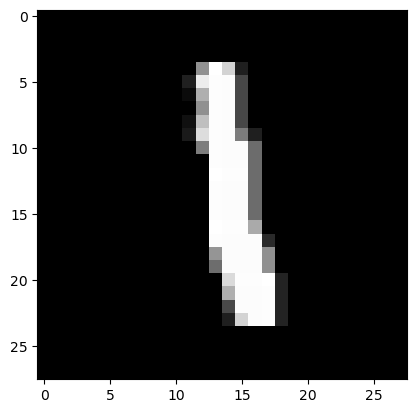

In [6]:
clue_image = trainset_mnist[6][0]
plt.imshow(clue_image[0].numpy(), cmap='gist_gray')
plt.show()

In [7]:
mnist_model = MNIST_CNN().to(DEVICE)
mnist_model.load_state_dict(torch.load('mnist_model.pt', DEVICE))
#model_labels = get_labels(model=mnist_model, data_loader=mnist_test_loader, device=DEVICE)
mnist_model.eval()

MNIST_CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=2, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)

# Compute outputs and activations

In [8]:
all_inputs_flat = torch.zeros((60_000, 28*28))
all_labels_10 = torch.zeros((60_000, ))
all_acts_L2 = torch.zeros((60_000, 200))
all_acts_features = torch.zeros((60_000, 400))
all_labels_challenge = torch.zeros((60_000, ))
all_conv1 = torch.zeros((60_000, 8, 13, 13))
all_conv2 = torch.zeros((60_000, 16, 5, 5))

idx = 0
for x, y in mnist_train_loader:

    bs = x.shape[0]
    all_inputs_flat[idx:idx+bs, :] = x.view(bs, -1)
    all_labels_10[idx:idx+bs] = y

    y_hat = mnist_model(x)
    all_acts_L2[idx:idx+bs] = mnist_model.get_neurons(x)
    _, pred_labels = torch.max(y_hat.data, 1)
    all_labels_challenge[idx:idx+bs] = torch.squeeze(pred_labels)
    all_conv1[idx:idx+bs] = mnist_model.get_conv1(x)
    all_conv2[idx:idx+bs] = mnist_model.get_conv2(x)
    all_acts_features[idx:idx+bs] = mnist_model.get_features(x)
    idx += bs

# Analysis

## Logit Diff direction

In [9]:
mnist_model

MNIST_CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=2, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)

`(fc2): Linear(in_features=200, out_features=2, bias=True)`

`_, pred_labels = torch.max(y_hat.data, 1)`

The label is determined by the difference in the two outputs. The difference is this given by
the constant bias-difference, and `(fc2.weight[0] - fc2.weight[1]) @ neurons`. Note that in this
notebook we refer to the 200-dim layer as "neurons" and the 400-dim layer as "features" just as
a matter of convention / variable names, with no wider meaning.

In [10]:
logit_diff_direction = (mnist_model.fc2.weight[0] - mnist_model.fc2.weight[1]).detach()
print("logit_diff_direction:", logit_diff_direction.shape)

logit_diff_direction: torch.Size([200])


## PCA in neurons

Variance explained: ['60.2%', '29.0%']


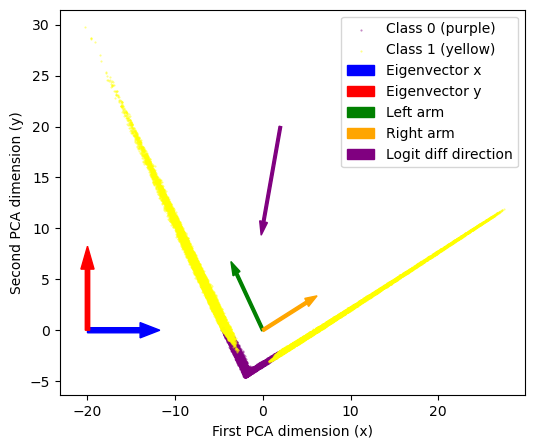

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(all_acts_L2.detach().numpy())
print("Variance explained:", [f"{r:.1%}" for r in pca.explained_variance_ratio_])
eigenvectors = torch.tensor(pca.components_)

pca_acts = pca.transform(all_acts_L2.detach().numpy())
logit_diff_direction_2d = pca.transform(logit_diff_direction.view(1, -1))[0]

# Quick linear regression to get the slope of the arms
from sklearn.linear_model import LinearRegression
split = pca_acts[:, 0] < -2
lr_left = LinearRegression()
lr_right = LinearRegression()
lr_left.fit(pca_acts[split, 0].reshape(-1, 1), pca_acts[split, 1])
lr_right.fit(pca_acts[~split, 0].reshape(-1, 1), pca_acts[~split, 1])
slope_left_2d = 3*torch.tensor([-1, -lr_left.coef_[0]])
slope_right_2d = 5*torch.tensor([1, lr_right.coef_[0]])
# Inverse transform
direction_left = torch.tensor(pca.inverse_transform(slope_left_2d.view(1, -1))[0])
direction_right = torch.tensor(pca.inverse_transform(slope_right_2d.view(1, -1))[0])

fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(pca_acts[all_labels_challenge==0, 0], pca_acts[all_labels_challenge==0, 1], c="purple", s=1, alpha=0.5, marker=".", label="Class 0 (purple)")
ax.scatter(pca_acts[all_labels_challenge==1, 0], pca_acts[all_labels_challenge==1, 1], c="yellow", s=1, alpha=0.5, marker=".", label="Class 1 (yellow)")
ax.set_xlabel("First PCA dimension (x)")
ax.set_ylabel("Second PCA dimension (y)")
ax.arrow(-20, 0, 6, 0, label="Eigenvector x", width=0.5, color="blue")
ax.arrow(-20, 0, 0, 6, label="Eigenvector y", width=0.5, color="red")
ax.arrow(0, 0, *slope_left_2d, width=0.3, color="green", label="Left arm")
ax.arrow(0, 0, *slope_right_2d, width=0.3, color="orange", label="Right arm")
ax.arrow(2, 20, 3*logit_diff_direction_2d[0], 2*logit_diff_direction_2d[1], color='purple', width=0.3, label="Logit diff direction")
ax.legend()

## Feature visualisation

### Particular directions

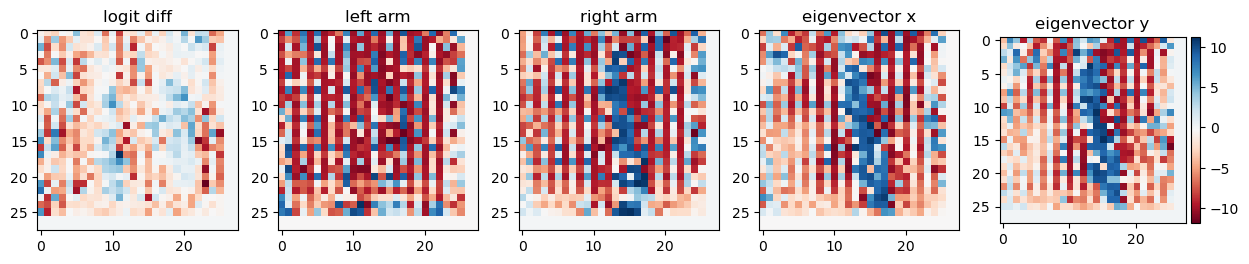

In [12]:
def find_pixels_that_maximize_direction(direction, num_epochs, show_iterations=True):
    pixel_image = Variable(torch.zeros((1,1,28,28)), requires_grad=True)
    optimizer = torch.optim.Adam([pixel_image], lr=1e-1, weight_decay=0)
    for i in range(num_epochs):
        A1 = mnist_model.get_neurons(pixel_image)
        V = -A1[0] @ direction # / (A1[0].norm() * direction.norm())
        if i % 100 == 0 and show_iterations:
            print("Iteration: {}; value: {}".format(i, V))
        V.backward()
        optimizer.step()
        optimizer.zero_grad()
    return(pixel_image)

directions = {"logit diff": logit_diff_direction,
              "left arm": direction_left,
              "right arm": direction_right,
              "eigenvector x": eigenvectors[0],
              "eigenvector y": eigenvectors[1]}

fig, axes = plt.subplots(1, len(directions), figsize=(15, 3))
for i, key in enumerate(directions.keys()):
    direction = directions[key]
    pixel_image = find_pixels_that_maximize_direction(direction, 100, show_iterations=False)
    im = axes[i].imshow(pixel_image.detach().numpy().reshape(28, 28), cmap="RdBu")
    axes[i].set_title(key)
# Add colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(axes[-1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()


### All 200 neurons

In [13]:
def find_pixels_that_maximize_neurons_pre(neuron, num_epochs, show_iterations=True):
    pixel_image = Variable(torch.zeros((1,1,28,28)), requires_grad=True)
    optimizer = torch.optim.Adam([pixel_image], lr=1e-1, weight_decay=0)
    for i in range(num_epochs):
        A1 = mnist_model.get_neurons_pre(pixel_image)
        V = -A1[:,neuron]
        if i % 100 == 0 and show_iterations:
            print("Iteration: {}; value: {}".format(i, V))
        V.backward()
        optimizer.step()
        optimizer.zero_grad()
    return(pixel_image)

feature_viz_neurons = []
for i in range(200):
    if i % 20 == 0: print(i)
    img = find_pixels_that_maximize_neurons_pre(neuron=i, num_epochs=100, show_iterations=False)
    feature_viz_neurons.append(img)


0
20
40
60
80
100
120
140
160
180


/tmp/ipykernel_26133/476451602.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


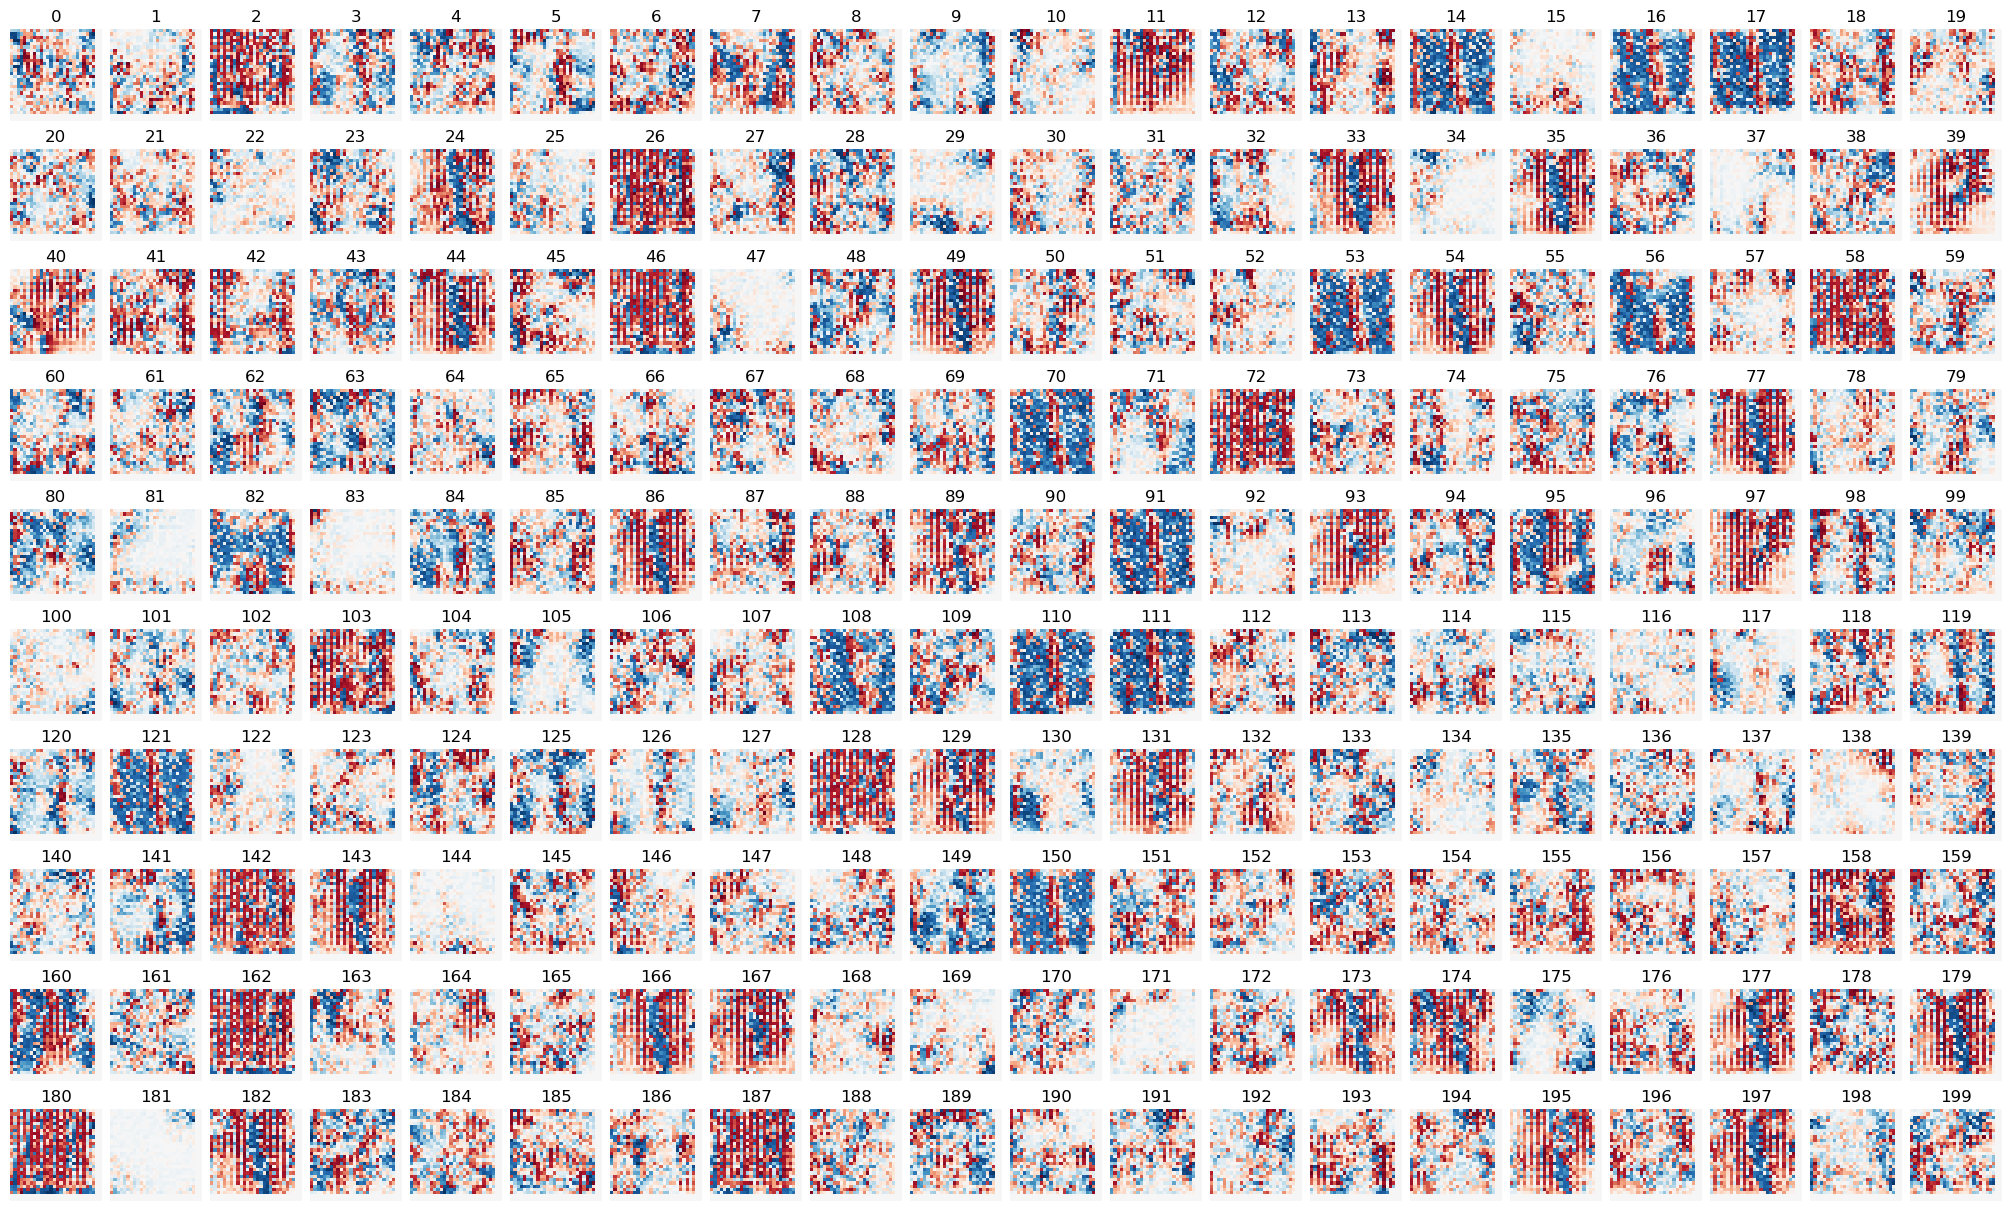

In [14]:
fig, ax = plt.subplots(10, 20, figsize=(20, 12), constrained_layout=True)
for i in range(20):
    for j in range(10):
        im = feature_viz_neurons[i+j*20]
        v_max = im.abs().max()
        ax[j,i].set_title(i+20*j)
        im = ax[j,i].imshow(im.view(28, 28).detach().numpy(), cmap='RdBu', vmax=v_max, vmin=-v_max)
        ax[j,i].axis('off')
fig.show()

## Eigenvectors and arm directions

/tmp/ipykernel_26133/1168882461.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


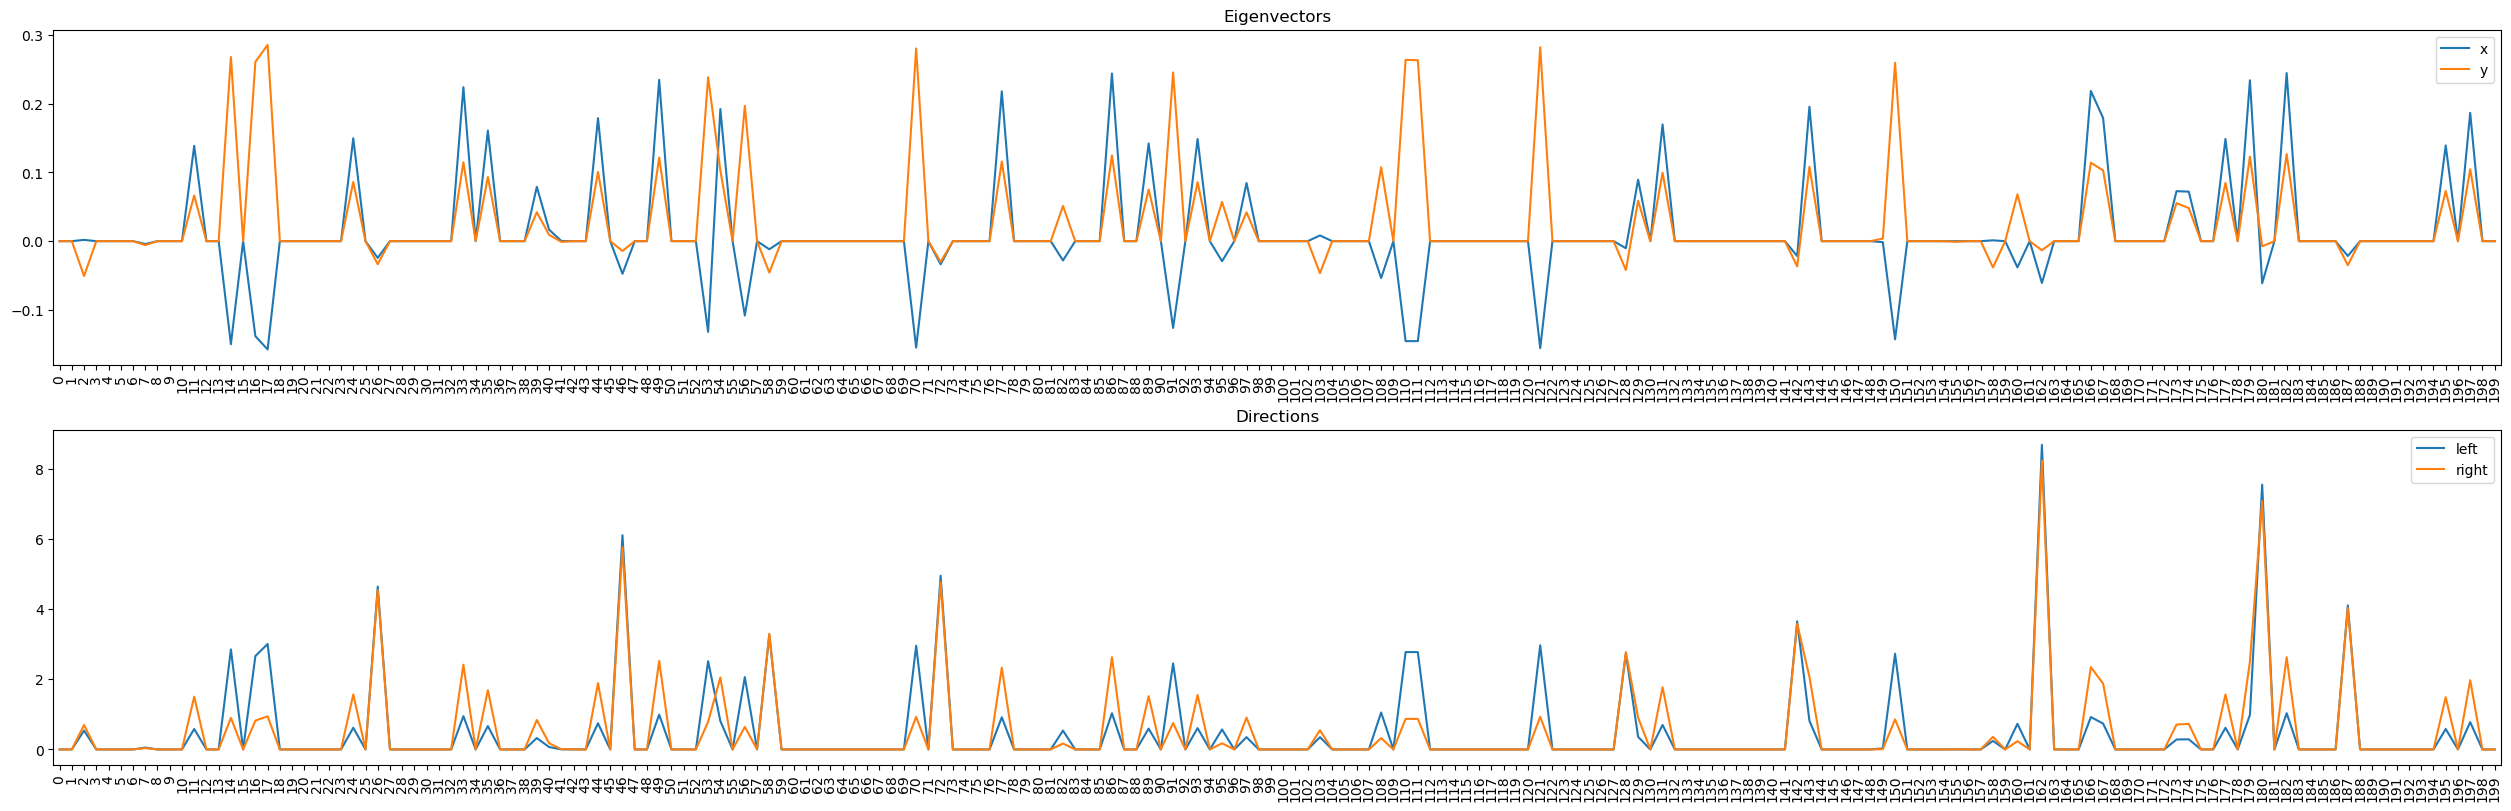

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(25, 8), constrained_layout=True)
axes[0].plot(eigenvectors[0], label="x")
axes[0].plot(eigenvectors[1], label="y")
axes[0].set_title("Eigenvectors")
axes[0].set_xticks(np.arange(200))
axes[0].set_xticklabels(np.arange(200), rotation=90)
axes[0].set_xlim(-0.5, 199.5)
axes[0].legend()
axes[1].plot(direction_left, label="left")
axes[1].plot(direction_right, label="right")
axes[1].set_title("Directions")
axes[1].set_xticks(np.arange(200))
axes[1].set_xticklabels(np.arange(200), rotation=90)
axes[1].set_xlim(-0.5, 199.5)
axes[1].legend()
fig.show()

### Aside: Neurons fireing always "pro-..."

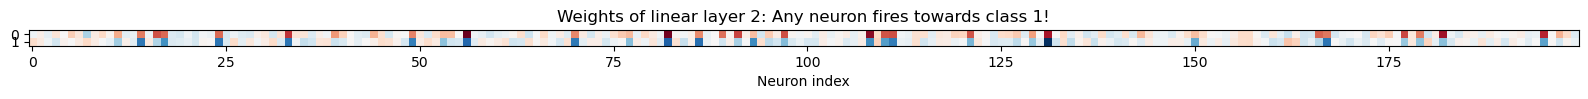

In [20]:
linear_W2 = mnist_model.fc2.weight.detach()
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
v_max = linear_W2.max()
ax.imshow(linear_W2, cmap='RdBu', vmax=v_max, vmin=-v_max)
ax.set_title("Weights of linear layer 2: Any neuron fires towards class 1!")
ax.set_xlabel("Neuron index")
plt.show()

## Ones on PCA

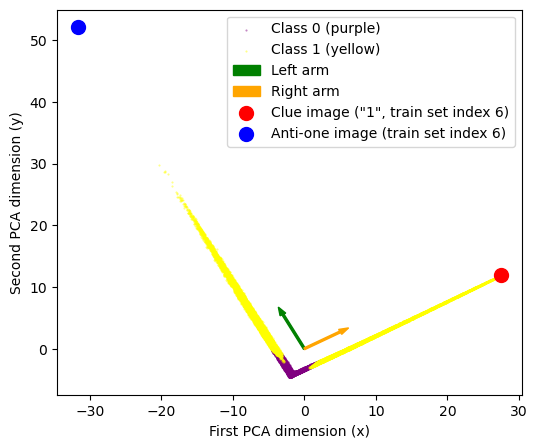

In [21]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(pca_acts[all_labels_challenge==0, 0], pca_acts[all_labels_challenge==0, 1], c="purple", s=1, alpha=0.5, marker=".", label="Class 0 (purple)")
ax.scatter(pca_acts[all_labels_challenge==1, 0], pca_acts[all_labels_challenge==1, 1], c="yellow", s=1, alpha=0.5, marker=".", label="Class 1 (yellow)")
ax.arrow(0, 0, *slope_left_2d, width=0.3, color="green", label="Left arm")
ax.arrow(0, 0, *slope_right_2d, width=0.3, color="orange", label="Right arm")
ax.set_xlabel("First PCA dimension (x)")
ax.set_ylabel("Second PCA dimension (y)")

clue_image = trainset_mnist[6][0]
clue_acts = pca_acts[6]
ax.scatter(clue_acts[0], clue_acts[1], c="red", s=100, marker="o", label='Clue image ("1", train set index 6)')

anti_one = 1 - clue_image
anti_one_acts = mnist_model.get_neurons(anti_one)[0].detach()
anti_one_acts_2d = pca.transform(anti_one_acts.view(1, -1))
ax.scatter(anti_one_acts_2d[0, 0], anti_one_acts_2d[0, 1], c="blue", s=100, marker="o", label='Anti-one image (train set index 6)')


ax.legend()

## Find precise label function

In [22]:
clue_image = trainset_mnist[6][0]
topleft_image = trainset_mnist[22752][0]
anti_one = 1 - clue_image
classification_image = clue_image - anti_one
# This is the same as clue_image - 0.5
assert torch.allclose(clue_image - anti_one, 2 * (clue_image - 0.5))

image = 1

-17305 < (image * (clue_image - 0.5)).sum() < -7762

dataset = mnist_train_loader.dataset.data
labels = all_labels_challenge
class0 = labels==0
class1 = labels==1

similarity = lambda image1=dataset, image2=classification_image: torch.sum(image1 * image2, dim=(-2, -1))

early_crit = similarity(dataset, clue_image - topleft_image)
final_criterion = similarity(dataset, classification_image)

In [23]:
def accuracy(left_boundary, right_boundary):
    success = list(labels[final_criterion < left_boundary] == 1) + \
              list(labels[torch.logical_and(final_criterion > left_boundary, final_criterion < right_boundary)] == 0) + \
              list(labels[final_criterion > right_boundary] == 1)
    return np.mean(success)

print("Accuracy:", accuracy(-17000,-8000))
# min_left = lambda left: -accuracy(left, -9000)
# from scipy.optimize import minimize_scalar
# opt_left = minimize_scalar(min_left, bounds=(-18000, -16000), method='bounded')
# print(opt_left)
left_boundary_final = -17305
# min_right = lambda right: -accuracy(left_boundary_final, right)
# from scipy.optimize import minimize_scalar
# opt_right = minimize_scalar(min_right, bounds=(-8500, -7000), method='bounded')
# print(opt_right)
right_boundary_final = -7762

print("Accuracy:", accuracy(left_boundary_final, right_boundary_final))

Accuracy: 0.9577166666666667
Accuracy: 0.9624666666666667


/tmp/ipykernel_26133/3346442162.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


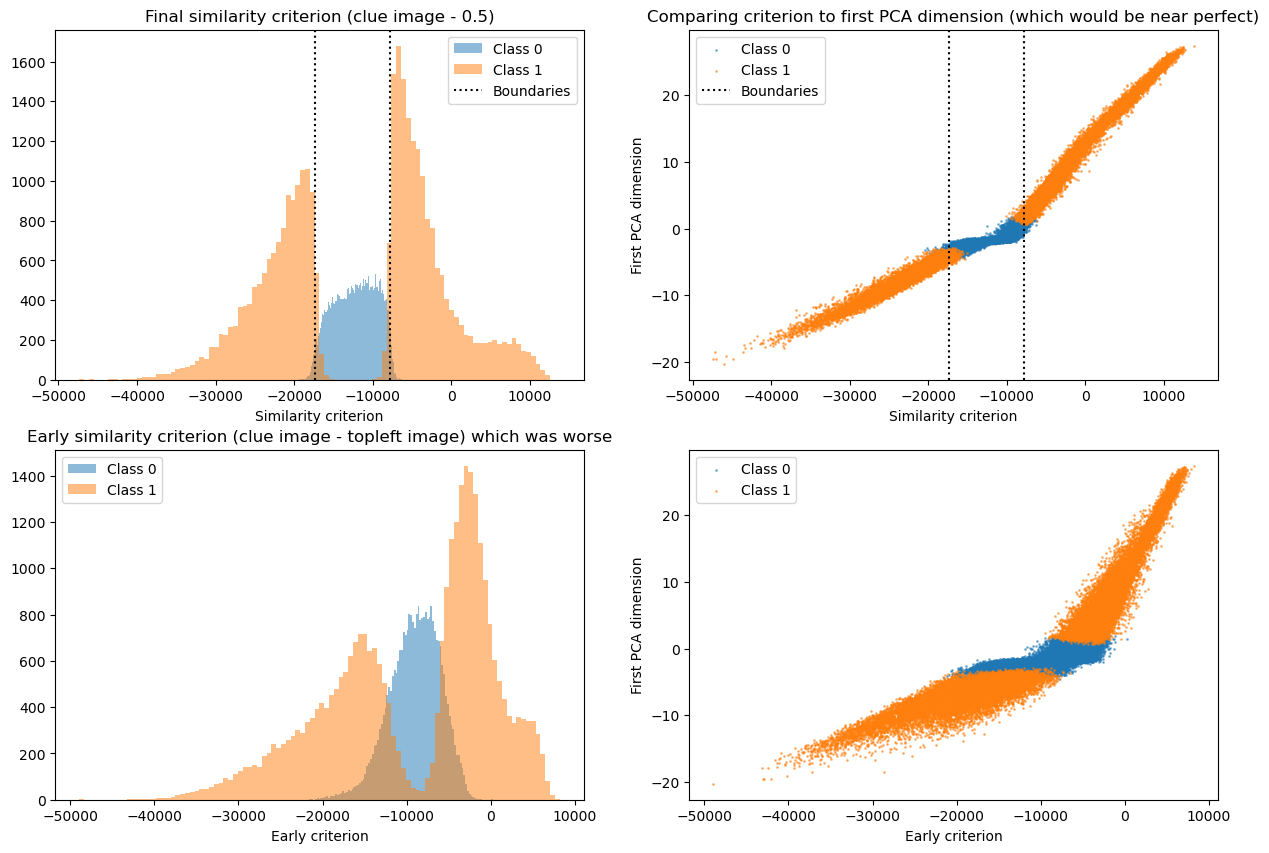

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0,0].set_title("Final similarity criterion (clue image - 0.5)")
axes[0,0].hist(final_criterion[class0], bins=100, alpha=0.5, label="Class 0")
axes[0,0].hist(final_criterion[class1], bins=100, alpha=0.5, label="Class 1")
axes[0,0].axvline(left_boundary_final, color="k", ls=":")
axes[0,0].axvline(right_boundary_final, color="k", ls=":", label="Boundaries")
axes[0,0].set_xlabel("Similarity criterion")
axes[0,0].legend()

axes[0,1].set_title("Comparing criterion to first PCA dimension (which would be near perfect)")
axes[0,1].scatter(final_criterion[class0], pca_acts[class0, 0], s=1, alpha=0.5, label="Class 0")
axes[0,1].scatter(final_criterion[class1], pca_acts[class1, 0], s=1, alpha=0.5, label="Class 1")
axes[0,1].axvline(left_boundary_final, color="k", ls=":")
axes[0,1].axvline(right_boundary_final, color="k", ls=":", label="Boundaries")
axes[0,1].set_xlabel("Similarity criterion")
axes[0,1].set_ylabel("First PCA dimension")
axes[0,1].legend()

axes[1,0].set_title("Early similarity criterion (clue image - topleft image) which was worse")
axes[1,0].hist(early_crit[class0], bins=100, alpha=0.5, label="Class 0")
axes[1,0].hist(early_crit[class1], bins=100, alpha=0.5, label="Class 1")
axes[1,0].set_xlabel("Early criterion")
axes[1,0].legend()

axes[1,1].scatter(early_crit[class0], pca_acts[class0, 0], s=1, alpha=0.5, label="Class 0")
axes[1,1].scatter(early_crit[class1], pca_acts[class1, 0], s=1, alpha=0.5, label="Class 1")
axes[1,1].set_xlabel("Early criterion")
axes[1,1].set_ylabel("First PCA dimension")
axes[1,1].legend()

fig.show()